# Deep Learning (AI2100/AI5100): Assignment-3 
## Name: Shagun 
## Roll No: cs23mtech14013

### Problem 2: Object Recognition with Vision Transformer  [10 Marks]

Implement and train an Encoder only Transformer (ViT-like) for the above object recognition task. In other words, implement multi-headed self-attention for the image classification (i.e., appending a < class > token to the image patches that are accepted as input tokens). Compare the performance of the two implementations (try to keep the number of parameters to be comparable and use the same amount of training and testing
data).

Breakdown of the code:

1. **Importing Libraries**: The necessary libraries are imported, including numpy, PyTorch modules (`nn`, `CrossEntropyLoss`, `Adam`, `DataLoader`), CIFAR-10 dataset from torchvision, and tqdm for progress bars.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor
from tqdm import tqdm, trange


2. **Seed Initialization**: Seeds for numpy and PyTorch are set to ensure reproducibility of results.

In [ ]:
np.random.seed(0)
torch.manual_seed(0)


3. **Data Patching**: The `patchify` function is defined to divide input images into patches. This function is specifically implemented for square images only.


In [ ]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches**2, h * w * c // n_patches**2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[
                    :,
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

4. **Multi-Head Self-Attention (MyMSA) Module**: A custom multi-head self-attention module is defined (`MyMSA`) using PyTorch's `nn.Module`. It performs multi-head self-attention on input sequences.

In [ ]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.k_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.v_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head**0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])


5. **Vision Transformer Block (MyViTBlock) Module**: A custom Vision Transformer block (`MyViTBlock`) is defined, which consists of layer normalization, multi-head self-attention, and a feedforward network (MLP).


In [ ]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out


6. **Vision Transformer (MyViT) Model**: A custom Vision Transformer model (`MyViT`) is defined, which consists of linear mapping of input patches, learnable classification token, positional embedding, transformer encoder blocks, and a classification MLP.


In [ ]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=8, n_blocks=2, hidden_d=8, n_heads=8, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_d),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList(
            [MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

        # 5) Classification MLPk
        self.mlp = nn.Sequential(nn.Linear(self.hidden_d, out_d), nn.Softmax(dim=-1))

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)  # Map to output dimension, output category distribution



7. **Positional Embeddings**: Positional embeddings are generated using the `get_positional_embeddings` function.


In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result



8. **Main Function**: The `main` function is defined, where the CIFAR-10 dataset is loaded, the model is instantiated, and training and testing loops are executed.

   - **Training Loop**: The model is trained using the CIFAR-10 training dataset. The Adam optimizer and cross-entropy loss function are used for training.
   
   - **Testing Loop**: The trained model is evaluated using the CIFAR-10 testing dataset.



In [ ]:
def main():
    # Loading data
    transform = ToTensor()

    train_set = CIFAR10(
        root="./../datasets", train=True, download=True, transform=transform
    )
    test_set = CIFAR10(
        root="./../datasets", train=False, download=True, transform=transform
    )

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(
        "Using device: ",
        device,
        f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "",
    )
    model = MyViT(
        (3, 32, 32), n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=10
    ).to(device)
    N_EPOCHS = 5
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(
            train_loader, desc=f"Epoch {epoch + 1} in training", leave=False
        ):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")


9. **Execution**: The `main` function is called to execute the training and testing process.

In [18]:
if __name__ == "__main__":
    main()


Files already downloaded and verified
Files already downloaded and verified
Using device:  cuda (Tesla T4)


Training:  20%|██        | 1/5 [05:01<20:05, 301.40s/it]              

Epoch 1/5 loss: 2.21



Training:  40%|████      | 2/5 [10:02<15:04, 301.44s/it]              

Epoch 2/5 loss: 2.15



Training:  60%|██████    | 3/5 [15:05<10:04, 302.01s/it]              

Epoch 3/5 loss: 2.13



Training:  80%|████████  | 4/5 [20:06<05:01, 301.71s/it]              

Epoch 4/5 loss: 2.12



Training: 100%|██████████| 5/5 [25:07<00:00, 301.57s/it]              


Epoch 5/5 loss: 2.11


Testing: 100%|██████████| 79/79 [00:39<00:00,  2.01it/s]

Test loss: 2.10
Test accuracy: 35.72%


In [ ]:
The above accuracy is achived with 5 epochs and 2 heads 

Running the same code with 40 epochs . Go to last to see graph of accuracy vs epochs 

In [31]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor
from tqdm import tqdm, trange

np.random.seed(0)
torch.manual_seed(0)


def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches**2, h * w * c // n_patches**2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[
                    :,
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches


class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.k_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.v_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head**0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])


class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out


class MyViT(nn.Module):
    def __init__(self, chw, n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_d),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList(
            [MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

        # 5) Classification MLPk
        self.mlp = nn.Sequential(nn.Linear(self.hidden_d, out_d), nn.Softmax(dim=-1))

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)  # Map to output dimension, output category distribution


def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result


def main():
    # Loading data
    transform = ToTensor()

    train_set = CIFAR10(
        root="./../datasets", train=True, download=True, transform=transform
    )
    test_set = CIFAR10(
        root="./../datasets", train=False, download=True, transform=transform
    )
    
    train_loader = DataLoader(train_set, shuffle=True, batch_size=1000)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=1000)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(
        "Using device: ",
        device,
        f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "",
    )
    
    model = MyViT(
        (3, 32, 32), n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=10
    ).to(device)
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        # Parallelize the model
        model = nn.DataParallel(model)
    model.to(device)

    N_EPOCHS = 40
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(
            train_loader, desc=f"Epoch {epoch + 1} in training", leave=False
        ):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")


if __name__ == "__main__":
    main()

Files already downloaded and verified
Files already downloaded and verified
Using device:  cuda (Tesla T4)
Let's use 2 GPUs!


Training:   2%|▎         | 1/40 [03:49<2:29:03, 229.32s/it]         

Epoch 1/40 loss: 2.28



Training:   5%|▌         | 2/40 [07:35<2:24:10, 227.65s/it]         

Epoch 2/40 loss: 2.22



Training:   8%|▊         | 3/40 [11:21<2:19:57, 226.95s/it]         

Epoch 3/40 loss: 2.18



Training:  10%|█         | 4/40 [15:06<2:15:33, 225.93s/it]         

Epoch 4/40 loss: 2.17



Training:  12%|█▎        | 5/40 [18:50<2:11:27, 225.36s/it]         

Epoch 5/40 loss: 2.15



Training:  15%|█▌        | 6/40 [22:36<2:07:45, 225.46s/it]         

Epoch 6/40 loss: 2.13



Training:  20%|██        | 8/40 [30:06<2:00:05, 225.18s/it]         

Epoch 8/40 loss: 2.11



Training:  22%|██▎       | 9/40 [33:51<1:56:21, 225.21s/it]         

Epoch 9/40 loss: 2.10



Training:  25%|██▌       | 10/40 [37:36<1:52:36, 225.23s/it]         

Epoch 10/40 loss: 2.10



Training:  28%|██▊       | 11/40 [41:21<1:48:52, 225.25s/it]         

Epoch 11/40 loss: 2.09



Training:  30%|███       | 12/40 [45:07<1:45:11, 225.40s/it]         

Epoch 12/40 loss: 2.09



Training:  32%|███▎      | 13/40 [48:52<1:41:23, 225.33s/it]         

Epoch 13/40 loss: 2.09



Training:  35%|███▌      | 14/40 [52:38<1:37:43, 225.52s/it]         

Epoch 14/40 loss: 2.08



Training:  38%|███▊      | 15/40 [56:26<1:34:17, 226.28s/it]         

Epoch 15/40 loss: 2.08



Training:  40%|████      | 16/40 [1:00:12<1:30:24, 226.02s/it]       

Epoch 16/40 loss: 2.08



Training:  42%|████▎     | 17/40 [1:03:59<1:26:47, 226.40s/it]       

Epoch 17/40 loss: 2.08



Training:  45%|████▌     | 18/40 [1:07:47<1:23:11, 226.89s/it]       

Epoch 18/40 loss: 2.07



Training:  48%|████▊     | 19/40 [1:11:33<1:19:18, 226.57s/it]       

Epoch 19/40 loss: 2.07



Training:  50%|█████     | 20/40 [1:15:19<1:15:27, 226.38s/it]       

Epoch 20/40 loss: 2.07



Training:  52%|█████▎    | 21/40 [1:19:05<1:11:38, 226.23s/it]       

Epoch 21/40 loss: 2.07



Training:  55%|█████▌    | 22/40 [1:22:50<1:07:48, 226.01s/it]       

Epoch 22/40 loss: 2.07



Training:  57%|█████▊    | 23/40 [1:26:35<1:03:56, 225.66s/it]       

Epoch 23/40 loss: 2.07



Training:  60%|██████    | 24/40 [1:30:20<1:00:09, 225.57s/it]       

Epoch 24/40 loss: 2.06



Training:  62%|██████▎   | 25/40 [1:34:07<56:29, 225.94s/it]         

Epoch 25/40 loss: 2.06



Training:  65%|██████▌   | 26/40 [1:37:53<52:42, 225.86s/it]         

Epoch 26/40 loss: 2.07



Training:  68%|██████▊   | 27/40 [1:41:39<48:57, 225.94s/it]         

Epoch 27/40 loss: 2.06



Training:  70%|███████   | 28/40 [1:45:25<45:12, 226.08s/it]         

Epoch 28/40 loss: 2.06



Training:  72%|███████▎  | 29/40 [1:49:12<41:27, 226.17s/it]         

Epoch 29/40 loss: 2.05



Training:  75%|███████▌  | 30/40 [1:52:59<37:45, 226.53s/it]         

Epoch 30/40 loss: 2.05



Training:  78%|███████▊  | 31/40 [1:56:46<34:00, 226.68s/it]         

Epoch 31/40 loss: 2.05



Training:  80%|████████  | 32/40 [2:00:34<30:14, 226.87s/it]         

Epoch 32/40 loss: 2.05



Training:  82%|████████▎ | 33/40 [2:04:21<26:29, 227.01s/it]         

Epoch 33/40 loss: 2.05



Training:  85%|████████▌ | 34/40 [2:08:08<22:42, 227.14s/it]         

Epoch 34/40 loss: 2.04



Training:  88%|████████▊ | 35/40 [2:11:54<18:53, 226.72s/it]         

Epoch 35/40 loss: 2.04



Training:  90%|█████████ | 36/40 [2:15:39<15:05, 226.26s/it]         

Epoch 36/40 loss: 2.04



Training:  92%|█████████▎| 37/40 [2:19:25<11:18, 226.08s/it]         

Epoch 37/40 loss: 2.04



Training:  95%|█████████▌| 38/40 [2:23:11<07:32, 226.05s/it]         

Epoch 38/40 loss: 2.04



Training:  98%|█████████▊| 39/40 [2:26:57<03:46, 226.12s/it]         

Epoch 39/40 loss: 2.04



Training: 100%|██████████| 40/40 [2:30:42<00:00, 226.06s/it]         


Epoch 40/40 loss: 2.04


Testing: 100%|██████████| 10/10 [00:31<00:00,  3.11s/it]

Test loss: 2.04
Test accuracy: 41.53%


Accuracy for 1 epoch 29%

Accuracy for 5 epochs 35%

Accuracy for 40 epochs 41.53%

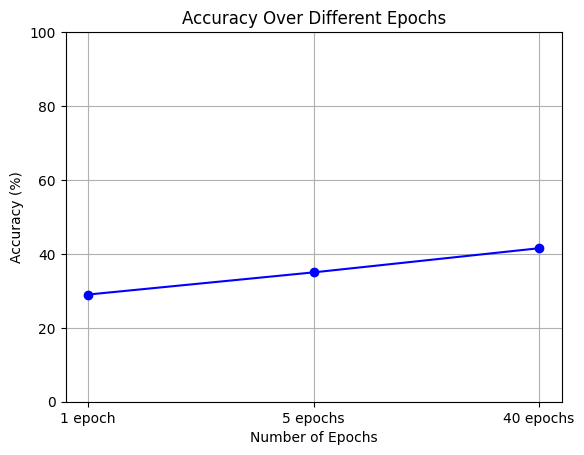

In [34]:
import matplotlib.pyplot as plt

epochs = ['1 epoch', '5 epochs', '40 epochs']
accuracy = [29, 35, 41.53]

plt.plot(epochs, accuracy, marker='o', color='blue', linestyle='-')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Different Epochs')
plt.grid(True)
plt.ylim(0, 100)  # Set y-axis limit to make the differences clearer
plt.show()

